## Adversarial pattern and covid masks agains facial recognition

The goal of this project is for you to experiment with the weaknesses of machine learning models and see by yourselves how easily they can be attacked (and defeated).

The goal of this project is to make you design a very simple version of an adversarial attack against a facial recognition model. 


### Goal

Facial recognition is probably one of the most dangerous application of machine learnings technics and one of the most vulnerable. Several applications use it to provide a way to identify people. For example tinder offers a feature to check if the picture on an account are actual pictures (to avoid catfishing) or some online banks use it to automatically retrieve access to an accout when a client has lost his credentials. The goal of this project is for you to design a proof of concept of an attack to fool the facial recognition system to make it believe you're someone else.

Most of the time these applications ask you to strike different poses in the picture they take to ensure you are actually using your camera and not feeding the system with pictures of someone else. That's why you'll need to design an algorithm to modify your picture in a way that makes you look like someone else in they eye of the model.

We suppose that we have a function to extract a face from a larger image, and then a function $\operatorname{Sig}$ which built a signature in $R^d$ from the face. We then use the usual $L_2$ distance to compare faces. Better, we compare the new face to all the signatures of all the faces of the known personn.

$\operatorname{D}(X, \text{Person 1}) = \frac1{|\text{Person 1}|} \sum_{I \in \text{Person 1}} ||X - I||_2$

This notebook has been partially completed to give you a reasonable base to begin the project. You don't have to use everything I added to this notebook and do everything on your own if you want to.

### The facial recognition library

You'll use this https://github.com/timesler/facenet-pytorch implementation of facenet and advertorch https://advertorch.readthedocs.io/en/latest/ to generate adversarial attacks. 
For more advanced part of the project you'll probably have to implement adversarial attacks by yourselves but it's a good way to start.

Make sure you ask for a GPU environnement in colab by setting in `Execution > Change execution type` and select GPU.

In [ ]:
!pip install facenet-pytorch

!pip install git+https://github.com/BorealisAI/advertorch.git

     |████████████████████████████████| 1.9 MB 7.6 MB/s 
  Cloning https://github.com/BorealisAI/advertorch.git to /tmp/pip-req-build-qdpvzpj6
  Running command git clone -q https://github.com/BorealisAI/advertorch.git /tmp/pip-req-build-qdpvzpj6
  Created wheel for advertorch: filename=advertorch-0.2.4-py3-none-any.whl size=6696880 sha256=923604a3438d5fb05f1fc32e3525ef6ba9b15ebe5f7ef7f57188571b449a65a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-qn6g_g8l/wheels/c4/c1/ae/7895deebcb976c70d587ded79871ae7a3185af71ee514c363b
Successfully built advertorch


In [ ]:
# Some technical things

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Mounting a directory from google drive

You'll make a directory `projets/faceattack` `projets/faceattack/me` and `projets/faceattack/target`, you can do as many targets or me folders as you want if you want to impersonate different people. and in your google drive and we will use it to store the "datasets" you'll be using. Namely the pictures of the person you want to impersonate and your own.

You can decide to use your own faces or take any celebrities on the internet, you'll just have to put at least one picture for the target (several is better to have a more robust attack) and at least one picture to tamper with.

In [ ]:
from pathlib import Path
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive')

PATH = Path('/content/drive/MyDrive/projets/faceattack')

Mounted at /content/drive


### Datasets and loading images


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms

class FolderDataset(Dataset):
  def __init__(self, dir : Path):
    self.paths = [dir / f for f in listdir(dir) if isfile(join(dir, f))]

  def __getitem__(self, i):
    im = Image.open(self.paths[i])
    return np.array(im)    
  
  def __len__(self):
    return len(self.paths)


# use to display pictures in google colab
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


In [ ]:
# Load each dataset using the class we just defined
target_dataset = FolderDataset(PATH / 'target/')
me_dataset = FolderDataset(PATH / 'me/')

### Facial recognition model

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization

# fixed_image_standardization is used to normalize a face 
# before feeding it to the resnet model

# Model used to detect faces in an image and to extract them
mtcnn = MTCNN(device=device, post_process = False)

# Model used to compare two faces and do the recognition part
resnet = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# Some utilities functions that you may need

# The mtcnn models returns boxes (x0, y0, x1, y1) in which the face should be
# contained
# Depending on the orientation of the image these might be permuted, this function
# makes sure that they are always in the same order
def permute_coords(img_shape, x0, y0, x1, y1):
  if img_shape[0] > img_shape[1]:
    return x0, y0, x1, y1
  else:
    return y0, x0, y1, x1

# This function crop and resize a face to normalize it so it can be fed to the
# recognition model
def crop_resize(im, box):
  x0, y0, x1, y1 = box
  crop = im[int(x0):int(x1), int(y0):int(y1), :]
  resize_fn = transforms.Resize((160, 160))
  crop = torch.Tensor(crop).transpose(0,2).transpose(1, 2)
  return resize_fn(crop).transpose(1,2).transpose(0,2).int()

# This function reverse the previous function
def revert_resize(im, box):
  resize_fn = transforms.Resize((int(abs(box[0] - box[2])), int(abs(box[1]-box[3]))))
  return resize_fn(im.transpose(0,2).transpose(1, 2).float()).transpose(1,2).transpose(0,2).int() 


In [ ]:
def generate_mask_uplft(input_image, window_shape, upper_left_points, gpu_number):
    """
    Function that generates mask that sets crops given upper_left
    corners to 0
    :param input_image:
    :param window_shape:
    :param upper_left_points:
    """
    N, C, H, W = input_image.size()
    window_h, window_w = window_shape
    # get the positions of masks
    mask_x_min = upper_left_points[:,:,0]
    mask_x_max = upper_left_points[:,:,0] + window_h
    mask_y_min = upper_left_points[:,:,1]
    mask_y_max = upper_left_points[:,:,1] + window_w
    # generate masks
    mask_x = Variable(torch.arange(0, H).view(-1, 1).repeat(N, C, 1, W))
    mask_y = Variable(torch.arange(0, W).view(1, -1).repeat(N, C, H, 1))
    if gpu_number is not None:
        device = torch.device("cuda:{}".format(gpu_number))
        mask_x = mask_x.cuda().to(device)
        mask_y = mask_y.cuda().to(device)
    x_gt_min = mask_x.float() >= mask_x_min.unsqueeze(-1).unsqueeze(-1).float()
    x_ls_max = mask_x.float() < mask_x_max.unsqueeze(-1).unsqueeze(-1).float()
    y_gt_min = mask_y.float() >= mask_y_min.unsqueeze(-1).unsqueeze(-1).float()
    y_ls_max = mask_y.float() < mask_y_max.unsqueeze(-1).unsqueeze(-1).float()

    # since logic operation is not supported for variable
    # I used * for logic ANd
    selected_x = x_gt_min * x_ls_max
    selected_y = y_gt_min * y_ls_max
    selected = selected_x * selected_y
    mask = 1 - selected.float()
    return mask 

### Some examples

Extracting my face and plotting it:

In [ ]:
# Extract my face

me_boxes = []
for i in range(len(me_dataset)):
  boxes, proba = mtcnn.detect(me_dataset[i])
  
  me_boxes.append(boxes[0])

me_boxes = [permute_coords(im.shape, *me_boxes[k]) for k, im in enumerate(me_dataset)]

#print(crop_resize(me_dataset[0], me_boxes[0]))

Create tensors for the "my" images

In [ ]:
# x_tensors=[]

# for i in range(len(me_dataset)):
#   cropped = crop_resize(me_dataset[i], me_boxes[i])
#   im = revert_resize(cropped, me_boxes[i]).transpose(0,2).transpose(1, 2).unsqueeze(0).to(device)
#   x_tensors.append(im)


# print(x_tensors[0])

fixed_image_standardization
x_tensors=[]

for i in range(len(me_dataset)):
  cropped = crop_resize(me_dataset[i], me_boxes[i])
  im = fixed_image_standardization(cropped).transpose(0,2).transpose(1, 2).unsqueeze(0).to(device)
  x_tensors.append(im)


#print(x_tensors[0])


torch.Size([160, 160, 3])


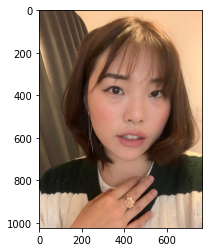

(1024, 768, 3)


In [ ]:
cropped = crop_resize(me_dataset[0], me_boxes[0])
print(cropped.shape)
# Initial picture
plt.imshow(me_dataset[0])
plt.show()
print(me_dataset[0].shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


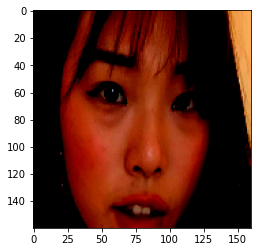

In [ ]:
# # Initial picture
# plt.imshow(me_dataset[5])
# plt.show()
# print(me_dataset[5].shape)

# Resized and croppped
cropped = crop_resize(me_dataset[0], me_boxes[0])
cropped=fixed_image_standardization(cropped)
#print(cropped.float())
plt.imshow(cropped)
plt.show()

# # Un-resized and croppped
# im = revert_resize(cropped, me_boxes[5])
# print(im.shape)
# plt.imshow(im)
# plt.show()

### Creating the signatures for the targeted face

In [ ]:
target_boxes = []
for i in range(len(target_dataset)):
  boxes, proba = mtcnn.detect(target_dataset[i])
  
  target_boxes.append(boxes[0])

target_boxes = [permute_coords(im.shape, *target_boxes[k]) for k, im in enumerate(target_dataset)]



In [ ]:
# # Initial picture
# for i in range(len(target_dataset)):
#   plt.imshow(target_dataset[i])
#   plt.show()
  

# # Resized and croppped
#   cropped = crop_resize(target_dataset[i], target_boxes[i])
#   plt.imshow(cropped)
#   plt.show()

# # Un-resized and croppped
#   im = revert_resize(cropped, target_boxes[i])
#   plt.imshow(im)
#   plt.show()

In [ ]:
## Create signatures / embeddings of the target face
signatures = []

resnet = resnet.to(device)

for i in range(len(target_dataset)):
  cropped = crop_resize(target_dataset[i], target_boxes[i])
  im = fixed_image_standardization(cropped).to(device)  #fixed_image_standardization normalize images in the range [0., 255.] into the range [-1.0, 1.0]
  
  #print(im.shape)
  #print(im.transpose(0,2).transpose(1, 2).unsqueeze(0).shape)
  sig = resnet(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()

  #print(sig.shape)
  signatures.append(sig.squeeze())
#print(signatures)
  
  
signatures = torch.stack(signatures)
print(signatures.shape)

torch.Size([8, 512])


In [ ]:

## Create signatures / embeddings of the me face
x = []

resnet = resnet.to(device)

for i in range(len(me_dataset)):
  cropped = crop_resize(me_dataset[i], me_boxes[i])
  im = fixed_image_standardization(cropped).to(device)  #fixed_image_standardization normalize images in the range [0., 255.] into the range [-1.0, 1.0]
  
  #print(im.shape)
  #print(im.transpose(0,2).transpose(1, 2).unsqueeze(0).shape)
  sig = resnet(im.transpose(0,2).transpose(1, 2).unsqueeze(0)).detach()


  x.append(sig.squeeze())
 
x = torch.stack(x)
print(x.shape)

torch.Size([6, 512])


In [ ]:
# defining the loss function to make the adversarial attack

# average distance to the target faces signature
def loss_fn(x, _):
  global signatures
  signatures = signatures.detach() # no gradients needed 
  diff = x.view(x.shape[0], 1, x.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1]).to(device) # tensor view reshape the vector without changing database (memory efficient)
  return -torch.norm(diff, dim=2).squeeze().mean()
print(loss_fn(x, signatures))

tensor(-1.0800, device='cuda:0')


### Implement facial attack with advertorch.attacks package and obtain the new distance between signatures

In [ ]:
from advertorch.attacks import MomentumIterativeAttack

adversary=MomentumIterativeAttack(resnet, loss_fn=loss_fn, eps=0.1, clip_min=-1, clip_max=1.0, targeted=False)

adv_pic=[]
perturbe_imgages=[]

for x in x_tensors:

  adv_targeted = adversary.perturb(x, y=None)
  perturbe_img=adv_targeted.squeeze().detach().transpose(1,2).transpose(0,2)*128.0+127.5
  adv_pic.append(adv_targeted)
  perturbe_imgages.append(perturbe_img.cpu().int().numpy())
  
# print(adv_pic[0])
# plt.imshow(adv_pic[0].squeeze().transpose(0,2).transpose(0,1).cpu())
# plt.show()

In [ ]:

## Create signatures / embeddings of the attacked face
x_attack = []

resnet = resnet.to(device)

for x in adv_pic:
  
  sig = resnet(x).detach()


  x_attack.append(sig.squeeze())
 
x_attack = torch.stack(x_attack)
# print(x_attack[0])

print(loss_fn(x_attack, signatures))

tensor(-0.5418, device='cuda:0')


### Print the perturbed picture 

(160, 160, 3)


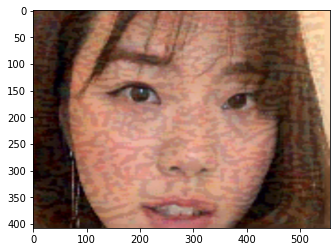

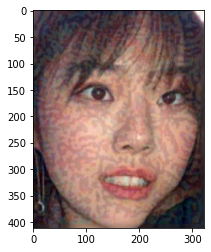

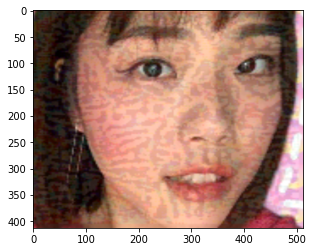

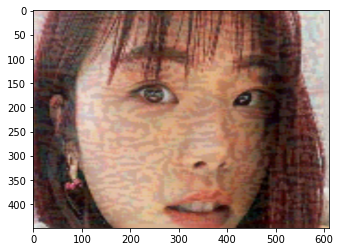

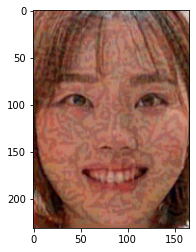

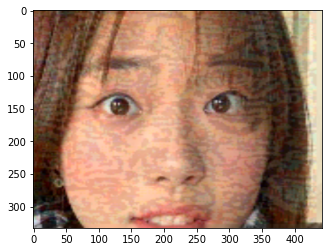

In [ ]:
print(perturbe_imgages[0].shape)

crop_perturb=[revert_resize(torch.Tensor(im),me_boxes[k]) for k, im in enumerate(perturbe_imgages)]

for k, im in enumerate(crop_perturb):
  if k>6:
    break
  plt.imshow(im)
  plt.show()

### paste the modified picture on the original picture

In [ ]:
from copy import deepcopy

perturb_full=[]
for k,im in enumerate(crop_perturb):
  x0,y0,x1,y1=[int(x) for x in me_boxes[k]]
  initial_im=me_dataset[k]
  initial_im[x0:x0+im.shape[0],y0:y0+im.shape[1]]=im.numpy()
  perturb_full.append(initial_im)

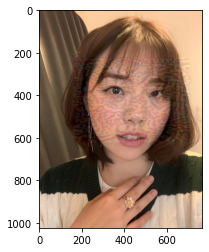

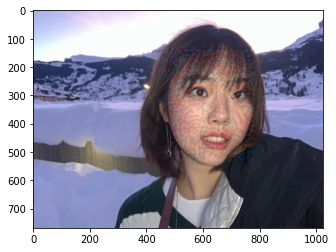

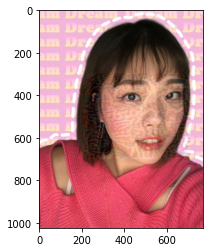

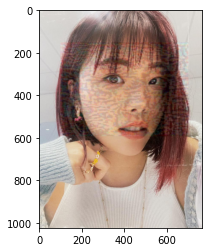

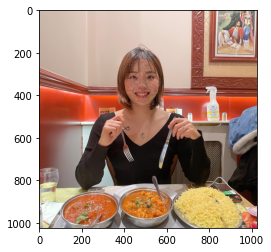

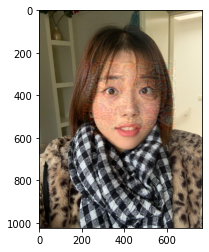

In [ ]:
for k, im in enumerate(perturb_full):
  if k>6:
    break
  plt.imshow(im)
  plt.show()


In [ ]:
print(loss_fn(x_attack, signatures))

tensor(-0.5418, device='cuda:0')


In [ ]:
def loss_fn_attack(x_attack, _):
  global x
  x = x.detach() # no gradients needed 
  diff = x_attack.view(x_attack.shape[0], 1, x_attack.shape[1]) - x.view(1, x.shape[0], x.shape[1]).to(device) # tensor view reshape the vector without changing database (memory efficient)
  return -torch.norm(diff, dim=2).squeeze().mean()
print(x.shape)

torch.Size([6, 512])


In [ ]:
#print(x_attack[1].shape)
print(loss_fn_attack(x_attack, x))

tensor(-1.0255, device='cuda:0')


In [ ]:
# Distance between the different faces of the targeted person
print(torch.norm(signatures.view(signatures.shape[0], 1, signatures.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1]), dim=2))
torch.norm(signatures.view(signatures.shape[0], 1, signatures.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1]), dim=2).squeeze().mean()
#dimon=signatures.view(signatures.shape[0], 1, signatures.shape[1]) - signatures.view(1, signatures.shape[0], signatures.shape[1])
#dimon2=torch.norm(dimon,dim=2)

# print(dimon.shape)
# print(dimon2.shape)
# print(signatures.view(signatures.shape[0], 1, signatures.shape[1]).shape)
# print(signatures.view(1, signatures.shape[0], signatures.shape[1]).shape)

tensor([[0.0000, 0.8699, 0.7577, 0.9178, 0.8598, 0.7674, 0.5845, 0.8764],
        [0.8699, 0.0000, 0.7124, 0.5563, 0.5463, 0.5016, 0.9384, 0.7731],
        [0.7577, 0.7124, 0.0000, 0.7323, 0.8082, 0.6710, 0.8682, 0.9081],
        [0.9178, 0.5563, 0.7323, 0.0000, 0.5453, 0.6994, 1.0589, 0.7687],
        [0.8598, 0.5463, 0.8082, 0.5453, 0.0000, 0.7928, 0.9790, 0.8039],
        [0.7674, 0.5016, 0.6710, 0.6994, 0.7928, 0.0000, 0.8869, 0.8504],
        [0.5845, 0.9384, 0.8682, 1.0589, 0.9790, 0.8869, 0.0000, 0.9485],
        [0.8764, 0.7731, 0.9081, 0.7687, 0.8039, 0.8504, 0.9485, 0.0000]],
       device='cuda:0')


tensor(0.6870, device='cuda:0')